In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

In [10]:
#variables controlled by the user. Change these to fit your specific needs.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution
"""
#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TEV", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH"]
"""

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"] #for plotting 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV"]
CLASSES = 2 #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph"]

TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(len(LABELS))] #The path to the folder containing the testing histogram files

MODEL_NAME = "resnet_1672847262"
LOAD_FOLDER = "/home/agrefsru/imcalML/results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

ampl.use_atlas_style()   

Running on the GPU


In [7]:
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), padding_mode=circular)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_siz

In [8]:
testpaths = [Path(path) for path in TEST_DATAPATHS]
print(testpaths)

test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)


[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_3000_events.h5')]


In [9]:
truth, preds = predict(model, test_data, CLASSES, 1, RES, DEVICE)
df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
global_accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 3000/3000 [00:30<00:00, 98.20it/s] 


In [11]:
#shuffle results
df = df.sample(frac=1)

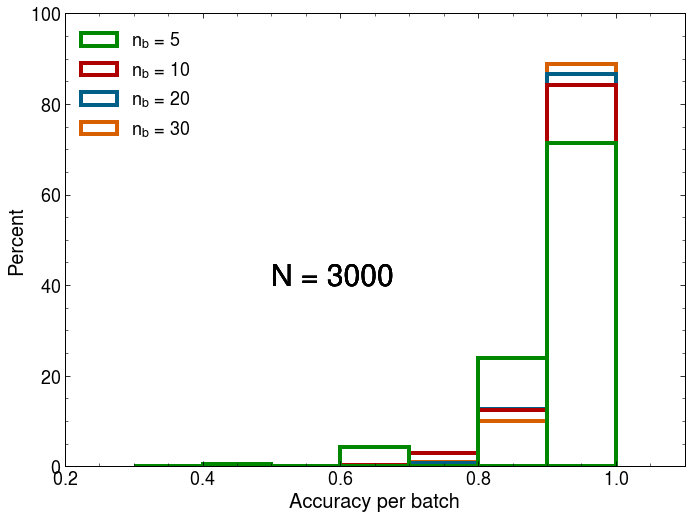

In [12]:
batch_sizes = [5, 10, 20, 30]
colors = ["red", "green", "blue"]
acc = {}
#acc = np.zeros((len(batch_sizes), int(TEST_N_EVENTS/batch_sizes[0])))
j = 0
for batch_size in batch_sizes:
    #shuffle results
    df = df.sample(frac=1)
    i = batch_size
    accuracies = []
    while i < TEST_N_EVENTS:
        predictions = df["Predictions"][i-batch_size:i]
        truths = df["Truth"][i-batch_size:i]
        accuracies.append(accuracy_score(truths, predictions, normalize=True))
        i = i + batch_size
    #print(color)
    #sn.histplot({f"batch size = {batch_size}": accuracies}, stat="percent", color=color)
    acc[f"$n_b$ = {batch_size}"] = accuracies 
    j = j + 1

    sn.histplot(acc, stat="percent", bins=7, binrange=(0.3, 1.0), multiple="layer", fill=False, common_norm=False, linewidth=4)
    plt.text(x = 0.5, y = 40, s = "N = 3000", fontsize=30)
    plt.xlabel("Accuracy per batch")

<AxesSubplot:ylabel='Percent'>

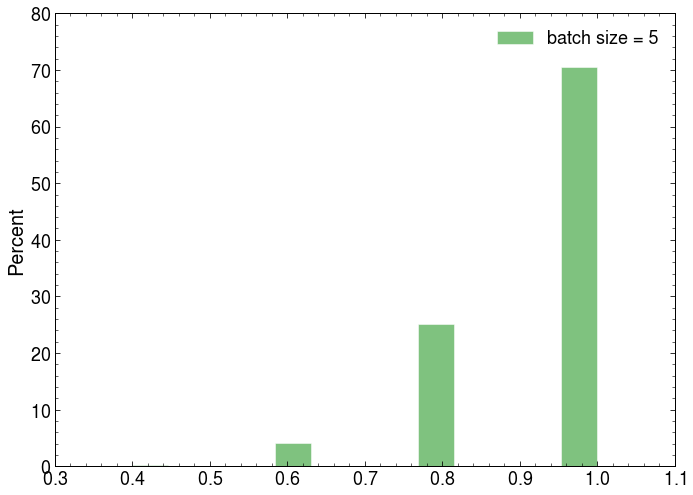

In [13]:
batch_size = 5
i = batch_size
accuracies = []
while i < TEST_N_EVENTS:
    predictions = df["Predictions"][i-batch_size:i]
    truths = df["Truth"][i-batch_size:i]
    accuracies.append(accuracy_score(truths, predictions, normalize=True))
    i = i + batch_size
sn.histplot({f"batch size = {batch_size}": accuracies}, stat="percent")

<AxesSubplot:ylabel='Count'>

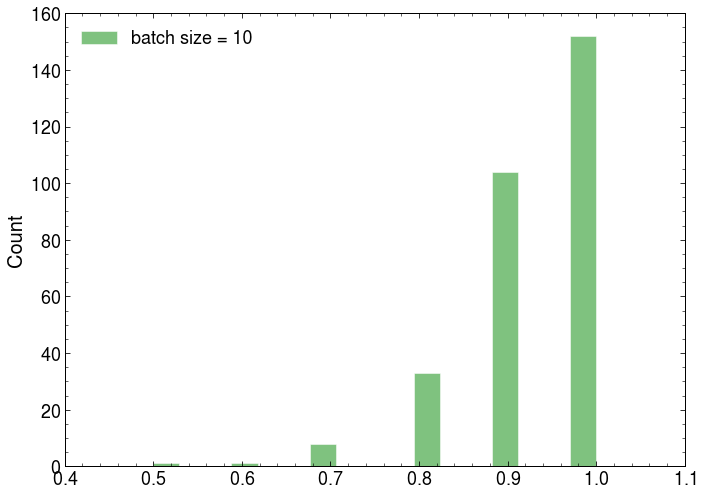

In [14]:
batch_size = 10
i = batch_size
accuracies = []
while i < TEST_N_EVENTS:
    predictions = df["Predictions"][i-batch_size:i]
    truths = df["Truth"][i-batch_size:i]
    accuracies.append(accuracy_score(truths, predictions, normalize=True))
    i = i + batch_size
sn.histplot({f"batch size = {batch_size}": accuracies})

<AxesSubplot:ylabel='Count'>

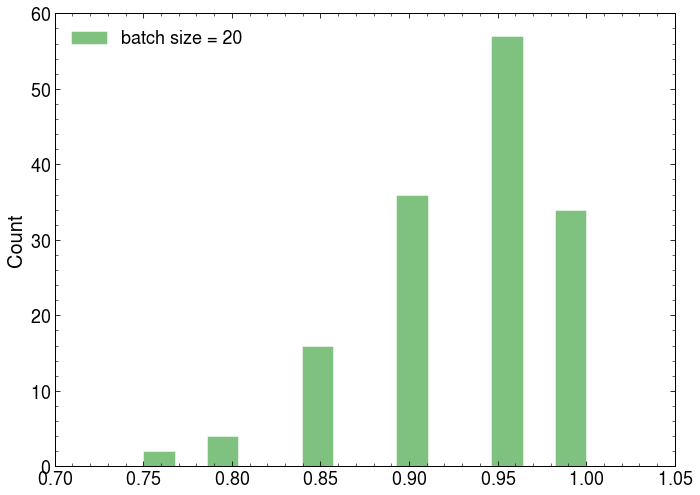

In [15]:
batch_size = 20
i = batch_size
accuracies = []
while i < TEST_N_EVENTS:
    predictions = df["Predictions"][i-batch_size:i]
    truths = df["Truth"][i-batch_size:i]
    accuracies.append(accuracy_score(truths, predictions, normalize=True))
    i = i + batch_size
sn.histplot({f"batch size = {batch_size}": accuracies})

<AxesSubplot:ylabel='Count'>

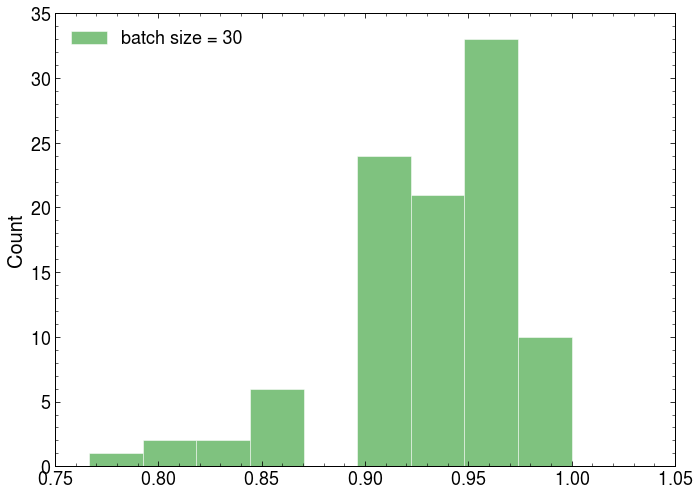

In [16]:
batch_size = 30
i = batch_size
accuracies = []
while i < TEST_N_EVENTS:
    predictions = df["Predictions"][i-batch_size:i]
    truths = df["Truth"][i-batch_size:i]
    accuracies.append(accuracy_score(truths, predictions, normalize=True))
    i = i + batch_size
sn.histplot({f"batch size = {batch_size}": accuracies})